![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Calibración de parámetros de redes neuronales
En este notebook aprenderá a calibrar parámetros de redes neuronales con dos diferentes metodologías usando la librería Keras y sklearn.model_selection.

## Instrucciones Generales

Este notebook esta compuesto por tres secciones. En la primera sección, usted beberá calibrar una red neuronal para predecir el precio de una casa con el set de datos Boston Housing Data con el método de Grid Search. En la segunda, se usará el mismo dataset pero usted beberá calibrar la red neuronal con el método de Randomized Search para identificar ventajas y diferencias entre los métodos. Para conocer más detalles de la base, puede ingresar al siguiente [vínculo](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/).
   
Para realizar la actividad, solo siga las indicaciones asociadas a cada celda del notebook. 

## Importar base de datos y librerías

In [1]:
# Importación librerías
import pandas as pd
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_boston
# Carga de datos de la librería sklearn
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


## Definición de variables predictoras  y de interés

In [3]:
# Definición de variables predictoras (X)
X = boston.drop(boston.columns[-1],axis=1)
# Definición de variable de interés (y)
Y = pd.DataFrame(np.array(boston_dataset.target), columns=['labels'])

In [4]:
# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test usandola función train_test_split
X_train, X_test , Y_train, Y_test = train_test_split(X,Y, test_size=0.3 ,random_state=22)

In [5]:
# Normalización de variables predictoras (X) con la función StandardScaler

# Definición de la función StandardScaler
scaler = StandardScaler()
scaler.fit(X)

# Transformación de los set de entrenamiento y test
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [6]:
# Definición de dimensiones de salida, varaibles de interés
output_var = Y_train.shape[1]
print(output_var, ' output variables')

1  output variables


In [7]:
# Definición de dimensiones de entrada, varaibles predictoras
dims = X_train.shape[1]
print(dims, 'input variables')

12 input variables


In [8]:
# Separación de datos de entrenamiento para considerar un set de validación durante entrenamiento
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)

## Red Neuronal

In [9]:
pip install livelossplot

In [10]:
# Importación librerías
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import metrics
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.callbacks import EarlyStopping
from keras import backend as K
from livelossplot import PlotLossesKeras

In [11]:
# Definición de función que crea una red neuronal a partir de diferentes parámetros
# En esta función se consideran 7 pa´rametos s calibrar, sin embargo se pueden agregar o quitar tantos como lo consideren pertinente
def nn_model_params(optimizer ,
                    neurons,
                    batch_size,
                    epochs,
                    activation,
                    patience,
                    loss):
    
    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()
    
    # Definición de las capas de la red con el número de neuronas y la función de activación definidos en la función nn_model_params
    model.add(Dense(neurons, input_shape=(dims,), activation=activation))
    model.add(Dense(neurons, activation=activation))
    model.add(Dense(output_var, activation=activation))

    # Definición de función de perdida con parámetros definidos en la función nn_model_params
    model.compile(optimizer = optimizer, loss=loss)
    
    # Definición de la función EarlyStopping con parámetro definido en la función nn_model_params
    early_stopping = EarlyStopping(monitor="val_loss", patience = patience)

    # Entrenamiento de la red neuronal con parámetros definidos en la función nn_model_params
    model.fit(X_train, Y_train,
              validation_data = (X_val, Y_val),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[early_stopping, PlotLossesKeras()],
              verbose=True
              )
     
    return model

In [12]:
# Definición de parámetros y sus valores sobre los que se va a calibrar
nn_params = {
    'optimizer': ['adam','sgd'],
    'activation': ['relu'],
    'batch_size': [64,128],
    'neurons':[64,256],
    'epochs':[20,50],
    'patience':[2,5],
    'loss':['mean_squared_error']
}

## Grid Search

La busqueda por cuadrícula es un método de calibración de parámetros donde se considera exhaustivamente todas las combinaciones de parámetros de un conjunto determinado.​

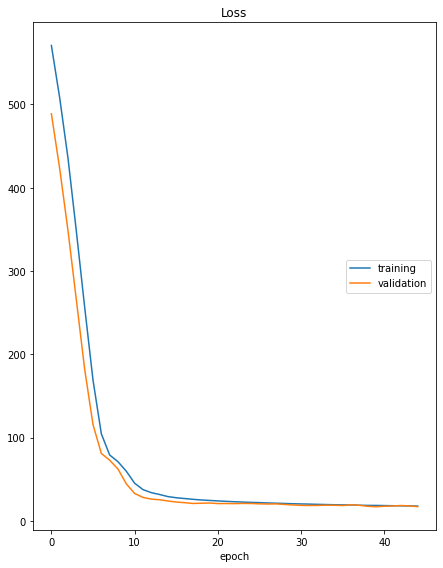

Loss
	training         	 (min:   17.915, max:  570.863, cur:   17.915)
	validation       	 (min:   17.079, max:  488.868, cur:   17.160)
Los mejores parametros segun Grid Search: {'activation': 'relu', 'batch_size': 64, 'epochs': 50, 'loss': 'mean_squared_error', 'neurons': 256, 'optimizer': 'adam', 'patience': 5}


In [13]:
from sklearn.model_selection import GridSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn la función nn_model_params
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición metodo GridSearch apra calibración de parámetros definidos en nn_params
gs = GridSearchCV(nn_model, nn_params, cv=3)
gs.fit(X_train, Y_train)

print('Los mejores parametros segun Grid Search:', gs.best_params_)

## Randomized Search

La busqueda aleatoria es un método de calibración de parámetros donde se considera combinaciones aleatorias de parámetros de un conjunto determinado.​

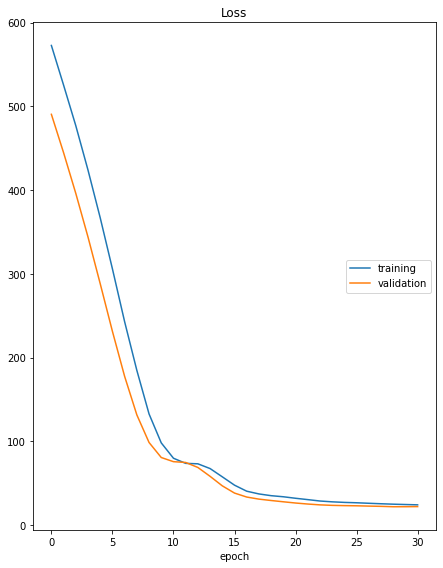

Loss
	training         	 (min:   24.067, max:  572.726, cur:   24.067)
	validation       	 (min:   21.808, max:  490.480, cur:   21.975)
Los mejores parametros segun Randomnized Search: {'patience': 2, 'optimizer': 'adam', 'neurons': 256, 'loss': 'mean_squared_error', 'epochs': 50, 'batch_size': 128, 'activation': 'relu'}


In [14]:
from sklearn.model_selection import RandomizedSearchCV

# Definición de red neuronal usando el wrapper KerasRegressor y usando como argumento build_fn la función nn_model_params
nn_model = KerasRegressor(build_fn=nn_model_params, verbose=0)

# Definición metodo GridSearch apra calibración de parámetros definidos en nn_params
rs = RandomizedSearchCV(nn_model, param_distributions=nn_params, n_iter=5, cv=3)
rs.fit(X_train, Y_train)

print('Los mejores parametros segun Randomnized Search:', rs.best_params_)

## Comparación resultados

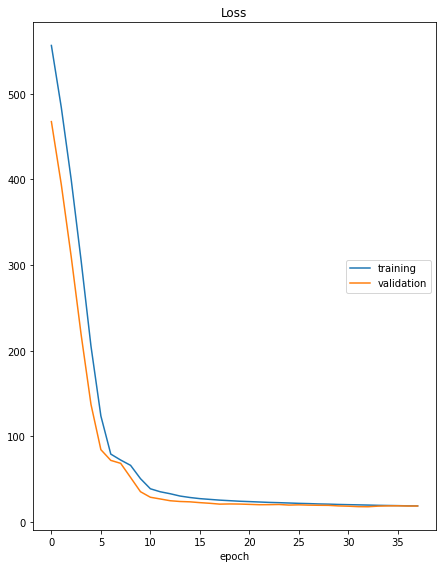

Loss
	training         	 (min:   18.930, max:  556.380, cur:   18.930)
	validation       	 (min:   17.972, max:  467.499, cur:   18.838)
Valor de  loss  o MSE dados los parámetros de Grid Search: 19.226661682128906


In [15]:
# Desempeño de modelo con los parametros de Grid Search
model = nn_model_params(optimizer = 'adam',
                        neurons=256,
                        batch_size=64,
                        epochs=50,
                        activation='relu',
                        patience=5,
                        loss='mean_squared_error')
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Valor de ", model.metrics_names[0] ," o MSE dados los parámetros de Grid Search:", scores)

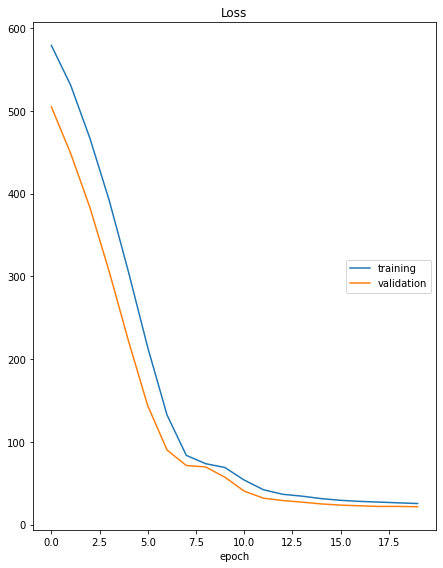

Loss
	training         	 (min:   25.357, max:  579.187, cur:   25.357)
	validation       	 (min:   21.478, max:  504.977, cur:   21.478)
Valor de  loss  o MSE dados los parámetros de Grid Search: 24.00908851623535


In [16]:
# Desempeño de modelo con los parametros de Randomized Search
model = nn_model_params(optimizer = 'adam',
                        neurons=256,
                        batch_size=64,
                        epochs=20,
                        activation='relu',
                        patience=5,
                        loss='mean_squared_error')
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Valor de ", model.metrics_names[0] ," o MSE dados los parámetros de Randomized Search:", scores)